In [1]:
import sys
sys.path.insert(0, "../..")

In [2]:
import os
import matplotlib.pyplot as plt
import numpy
import math
import spatialpy

In [3]:
class Membrane(spatialpy.Geometry):
    def __init__(self, radius_external, radius_internal):
        spatialpy.Geometry.__init__(self)
        self.radius_external = radius_external
        self.radius_internal = radius_internal
        
    def inside(self, point, on_boundary):
        r = numpy.sqrt(point[0]**2 + point[1]**2)
        return self.radius_external >= r >= self.radius_internal

In [4]:
class Cytoplasm(spatialpy.Geometry):
    def __init__(self, radius_external, radius_internal):
        spatialpy.Geometry.__init__(self)
        self.radius_external = radius_external
        self.radius_internal = radius_internal
        
    def inside(self, point, on_boundary):
        r = numpy.sqrt(point[0]**2 + point[1]**2)
        return r < self.radius_internal

In [5]:
class GbgGradient(spatialpy.DataFunction):
    def __init__(self, Gbg_mid=5000, Gbg_slope=0.0, mem_vol=1.0):
        """ 1D domain from a to b. """
        spatialpy.DataFunction.__init__(self, name="GbgGradient")
        self.Gbg_mid = Gbg_mid
        self.Gbg_slope = Gbg_slope
        self.mem_vol = mem_vol
        
    def expression(self):
        return f"({self.Gbg_slope} * me->x[1] + {self.Gbg_mid}) / {self.mem_vol}"
    
    def map(self, x):
        return (self.Gbg_slope * x[1] + self.Gbg_mid) / self.mem_vol

In [6]:
class Cdc42_cycle_2D_SpatialPy_SDPD(spatialpy.Model):
    EXTRA_CELLULAR = "Extra_Cellular"
    MEMBRANE = Membrane.__name__
    CYTOPLASM = Cytoplasm.__name__
    
    def __init__(self, model_name="Cdc42_2D", end_time=None, DX=10):
        spatialpy.Model.__init__(self, model_name)
        
        #################################################
        Gbg_conc = 5000.0
        Gbg_pct_slope = 0.0
        delta1_val = 0.00297
        delta1_gbg_val = 0.00297
        delta_neg_val = 1.0 / 30000
        #################################################
        radius_external = 0.6
        radius_internal = 0.4
        
        domain = spatialpy.Domain.create_2D_domain(
            xlim=(-1, 1), ylim=(-1, 1), nx=DX, ny=DX, rho0=1.0, c0=10, P0=10, type_id=self.EXTRA_CELLULAR
        )
        domain.set_properties(
            Membrane(radius_external, radius_internal), type_id=self.MEMBRANE, mass=4.0, nu=1.0, fixed=False
        )
        domain.set_properties(
            Cytoplasm(radius_external, radius_internal), type_id=self.CYTOPLASM, mass=2.0, nu=1.0, fixed=False
        )
        self.add_domain(domain)

        #################################################
        extra_cellular_volume = 0
        extra_cellular_count = 0
        membrane_volume = 0
        membrane_count = 0
        cytoplasm_volume = 0
        cytoplasm_count = 0
        for voxel_index, voxel_coords in enumerate(self.domain.coordinates()):
            if self.domain.type_id[voxel_index] == self.domain.get_type_def(self.EXTRA_CELLULAR):
                extra_cellular_volume = extra_cellular_volume + self.domain.vol[voxel_index]
                extra_cellular_count += 1
            elif self.domain.type_id[voxel_index] == self.domain.get_type_def(self.MEMBRANE):
                membrane_volume = membrane_volume + self.domain.vol[voxel_index]
                membrane_count += 1
            elif self.domain.type_id[voxel_index] == self.domain.get_type_def(self.CYTOPLASM):
                cytoplasm_volume = cytoplasm_volume + self.domain.vol[voxel_index]
                cytoplasm_count+=1
            
        true_cytoplasm_volume = math.pi * radius_internal * radius_internal
        true_membrane_volume = math.pi * radius_external * radius_external - true_cytoplasm_volume
        membrane_error = abs(true_membrane_volume - membrane_volume) / true_membrane_volume * 100
        cytoplasm_error = abs(true_cytoplasm_volume - cytoplasm_volume) / true_cytoplasm_volume * 100
        
        print(f"Volumes:  DX={DX}")
        print(f"\textracellular\t{extra_cellular_volume} ({extra_cellular_count} paticles)")
        print(f"\tmembrane\t{membrane_volume} ({membrane_count} paticles)\t{membrane_error:.2f}% error")
        print(f"\tcytoplasm\t{cytoplasm_volume} ({cytoplasm_count} paticles)\t{cytoplasm_error:.2f}% error")
        #################################################
        
        D_membrane = 0.0053   #diffusion on the membrane from PLOS paper
        D_GDP = 0.0053
        D_GTP = 0.0053
        D_bulk = 10.0
        
        # Species
        Cdc24_m = spatialpy.Species(name="Cdc24_m", diffusion_coefficient=D_membrane, restrict_to=self.MEMBRANE)
        Cdc24_c = spatialpy.Species(
            name="Cdc24_c", diffusion_coefficient=D_bulk, restrict_to=[self.MEMBRANE, self.CYTOPLASM]
        )
        Cdc42 = spatialpy.Species(name="Cdc42", diffusion_coefficient=D_GDP, restrict_to=self.MEMBRANE)
        Cdc42_a = spatialpy.Species(name="Cdc42_a", diffusion_coefficient=D_GTP, restrict_to=self.MEMBRANE)
        Bem1_m = spatialpy.Species(name="Bem1_m", diffusion_coefficient=D_membrane, restrict_to=self.MEMBRANE)
        Bem1_c = spatialpy.Species(
            name="Bem1_c", diffusion_coefficient=D_bulk, restrict_to=[self.MEMBRANE, self.CYTOPLASM]
        )
        Cla4 = spatialpy.Species(
            name="Cla4", diffusion_coefficient=D_bulk, restrict_to=[self.MEMBRANE, self.CYTOPLASM]
        )
        Cla4_a = spatialpy.Species(name="Cla4_a", diffusion_coefficient=D_membrane, restrict_to=self.MEMBRANE)
        Cdc42_c = spatialpy.Species(
            name="Cdc42_c", diffusion_coefficient=D_bulk, restrict_to=[self.MEMBRANE, self.CYTOPLASM]
        )
        self.add_species([Cdc24_m, Cdc24_c, Cdc42, Cdc42_a, Bem1_m, Bem1_c, Cla4, Cla4_a, Cdc42_c])

        #################################################
        # Parameters
        k_42d = spatialpy.Parameter(name="k_42d", expression=1.0)
        k_42a = spatialpy.Parameter(name="k_42a", expression=0.2)
        k_24cm1 = spatialpy.Parameter(name="k_24cm1", expression=delta1_val)
        k_24mc = spatialpy.Parameter(name="k_24mc", expression=0.35) 
        k_B1mc = spatialpy.Parameter(name="k_B1mc", expression=0.35)
        k_B1cm = spatialpy.Parameter(name="k_B1cm", expression=0.2667)
        k_Cla4a = spatialpy.Parameter(name="k_Cla4a", expression=0.006)
        k_Cla4d = spatialpy.Parameter(name="k_Cla4d", expression=0.01)
        k_24d = spatialpy.Parameter(name="k_24d", expression=delta_neg_val)
        beta1 = spatialpy.Parameter(name="beta1", expression=0.266) 
        beta2 = spatialpy.Parameter(name="beta2", expression=0.28)
        beta3 = spatialpy.Parameter(name="beta3", expression=1.0) 
        delta1_gbg = spatialpy.Parameter(name="delta1_gbg", expression=delta1_gbg_val)
        self.add_parameter([
            k_42a, k_42d, k_24cm1, k_24mc, k_B1mc, k_B1cm, k_Cla4a, k_Cla4d,
            k_24d,beta1, beta2, beta3,delta1_gbg
        ])

        # Add Data Function to model the mating pheromone gradient.
        self.add_data_function(GbgGradient(
            Gbg_mid=Gbg_conc,
            Gbg_slope=Gbg_conc * Gbg_pct_slope / (radius_external * 2.0),
            mem_vol=membrane_volume
        ))

        # Reactions
        CR0 = spatialpy.Reaction(
            name="CR0", reactants={Cdc24_c:1}, products={Cdc24_m:1},
            propensity_function="delta1_gbg * Cdc24_c * GbgGradient * vol", restrict_to=self.MEMBRANE
        )
        CR1 = spatialpy.Reaction(name="CR1", reactants={Cdc24_c:1,Bem1_m:1}, products={Cdc24_m:1,Bem1_m:1},
                                 rate=k_24cm1, restrict_to=self.MEMBRANE)
        CR2 = spatialpy.Reaction(name="CR2", reactants={Cdc24_m:1}, products={Cdc24_c:1},
                                 rate=k_24mc, restrict_to=self.MEMBRANE)
        CR3 = spatialpy.Reaction(name="CR3", reactants={Cdc24_m:1, Cla4_a:1}, products={Cdc24_c:1 ,Cla4_a:1},
                                 rate=k_24d, restrict_to=self.MEMBRANE)
        CR4 = spatialpy.Reaction(name="CR4", reactants={Cdc24_m:1, Cdc42:1}, products={Cdc24_m:1, Cdc42_a:1},
                                 rate=k_42a, restrict_to=self.MEMBRANE)
        CR5 = spatialpy.Reaction(name="CR5", reactants={Cdc42_a:1}, products={Cdc42:1},
                                 rate=k_42d, restrict_to=self.MEMBRANE)
        CR6 = spatialpy.Reaction(name="CR6", reactants={Cdc42_a:1, Bem1_c:1}, products={Cdc42_a:1, Bem1_m:1},
                                 rate=k_B1cm, restrict_to=self.MEMBRANE)
        CR7 = spatialpy.Reaction(name="CR7", reactants={Bem1_m:1}, products={Bem1_c:1},
                                 rate=k_B1mc, restrict_to=self.MEMBRANE)
        CR8 = spatialpy.Reaction(name="CR8", reactants={Cdc42_a:1, Cla4:1}, products={Cdc42_a:1, Cla4_a:1},
                                 rate=k_Cla4a, restrict_to=self.MEMBRANE)
        CR9 = spatialpy.Reaction(name="CR9", reactants={Cla4_a:1}, products={Cla4:1},
                                 rate=k_Cla4d, restrict_to=self.MEMBRANE)
        CR10 = spatialpy.Reaction(name="CR10", reactants={Cdc42_c:1}, products={Cdc42:1},
                                  rate=beta2, restrict_to=self.MEMBRANE)
        CR11 = spatialpy.Reaction(name="CR11", reactants={Cdc42:1}, products={Cdc42_c:1},
                                  rate=beta3, restrict_to=self.MEMBRANE)
        CR12 = spatialpy.Reaction(name="CR12", reactants={Cdc42_c:1, Cdc24_m:1},
                                  products={Cdc42_a:1, Cdc24_m:1}, rate=beta1, restrict_to=self.MEMBRANE)
        self.add_reaction([CR0, CR1, CR2, CR3, CR4, CR5, CR6, CR7, CR8, CR9, CR10, CR11, CR12])
        
        # Scatter initial condition
        self.add_initial_condition(spatialpy.ScatterInitialCondition(Cdc42, 2700, [self.CYTOPLASM]))
        self.add_initial_condition(spatialpy.ScatterInitialCondition(Cdc24_c, 1000, [self.MEMBRANE]))
        self.add_initial_condition(spatialpy.ScatterInitialCondition(Bem1_c, 3000, [self.MEMBRANE]))
        self.add_initial_condition(spatialpy.ScatterInitialCondition(Cla4, 5000, [self.MEMBRANE]))
        self.add_initial_condition(spatialpy.ScatterInitialCondition(Cdc42_a, 300, [self.CYTOPLASM]))

        # Do not allow points to move
        self.staticDomain = True

        # Set timestep
        self.timestep_size = 1
        
        if end_time is None:
            end_time = 1000
        num_steps = end_time + 1 if end_time >= 1.0 else 10
        self.timespan(numpy.linspace(0, end_time, num_steps))
        print("simulating to {0}s".format(end_time))

In [7]:
for dx in range(10,100,10):
    model = Cdc42_cycle_2D_SpatialPy_SDPD(DX=dx)

Volumes:  DX=10
	extracellular	3.040000000000002 (76 paticles)
	membrane	0.4799999999999999 (12 paticles)	23.61% error
	cytoplasm	0.4799999999999999 (12 paticles)	4.51% error
simulating to 1000s
Volumes:  DX=20
	extracellular	3.039999999999979 (304 paticles)
	membrane	0.5200000000000002 (52 paticles)	17.24% error
	cytoplasm	0.4400000000000002 (44 paticles)	12.46% error
simulating to 1000s
Volumes:  DX=30
	extracellular	2.9333333333333007 (660 paticles)
	membrane	0.5688888888888879 (128 paticles)	9.46% error
	cytoplasm	0.4977777777777763 (112 paticles)	0.97% error
simulating to 1000s
Volumes:  DX=40
	extracellular	2.919999999999949 (1168 paticles)
	membrane	0.5999999999999982 (240 paticles)	4.51% error
	cytoplasm	0.48000000000000037 (192 paticles)	4.51% error
simulating to 1000s
Volumes:  DX=50
	extracellular	2.9119999999999404 (1820 paticles)
	membrane	0.608000000000001 (380 paticles)	3.23% error
	cytoplasm	0.479999999999998 (300 paticles)	4.51% error
simulating to 1000s
Volumes:  DX=6

In [8]:
model = Cdc42_cycle_2D_SpatialPy_SDPD(end_time=100)

Volumes:  DX=10
	extracellular	3.040000000000002 (76 paticles)
	membrane	0.4799999999999999 (12 paticles)	23.61% error
	cytoplasm	0.4799999999999999 (12 paticles)	4.51% error
simulating to 100s


In [9]:
%time result = model.run(debug_level=0)

CPU times: user 21.8 ms, sys: 8.08 ms, total: 29.9 ms
Wall time: 4min 21s


In [10]:
Cdc42_vals = result.get_species("Cdc42_a", debug=False)

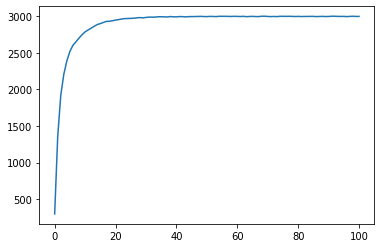

In [11]:
plt.plot(result.get_timespan(), Cdc42_vals.sum(axis=1))

In [12]:
type_vals = result.get_property("type", 0)

In [13]:
Cdc42_a_results = result.get_species("Cdc42_a", deterministic=True, debug=False)
print(numpy.amax(Cdc42_a_results))

nan


In [14]:
def plot_step(t_ndx, key='type'):
    pts, data = result.read_step(t_ndx)
    plt.figure(figsize=(15, 10) )
    plt.scatter(pts[:, 0], pts[:, 1], c=data[key])
    plt.axis('equal')
    plt.colorbar()
    plt.title(f't={t_ndx}')
    
def plot_all(key='type'):
    for i, t in enumerate(result.get_timespan()):
        if i % 10 == 0:
            plot_step(i, key)

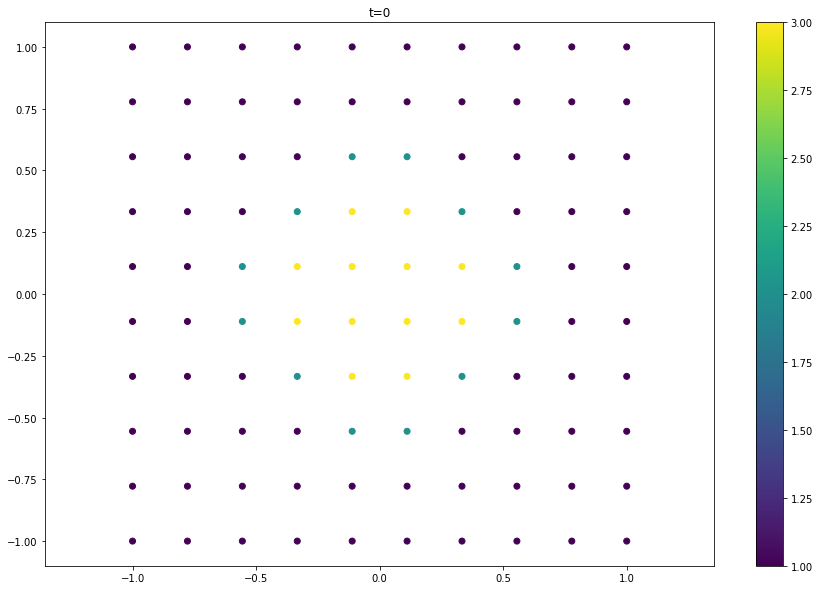

In [15]:
plot_step(0, key='type')

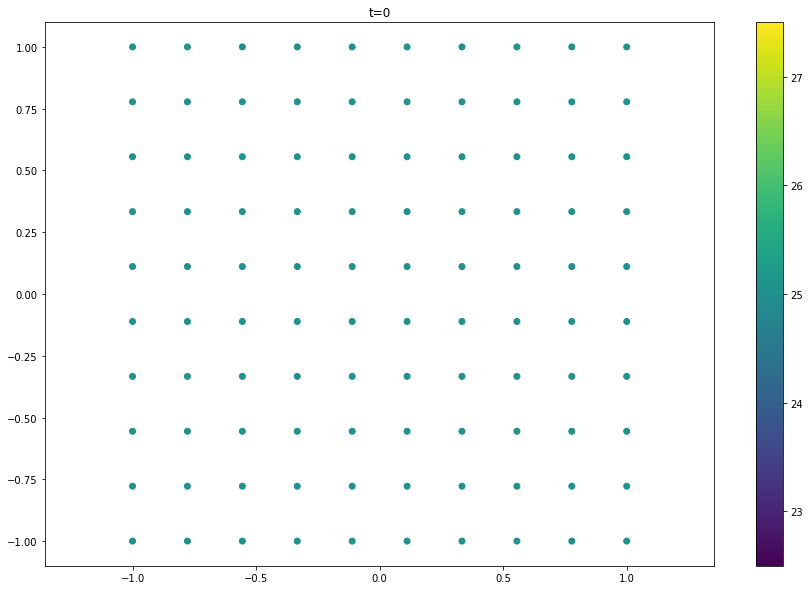

In [16]:
plot_step(0, key="rho")

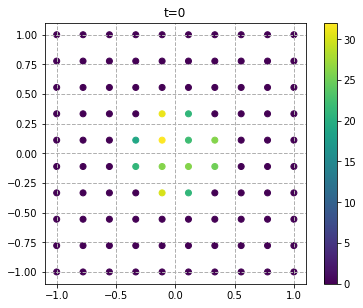

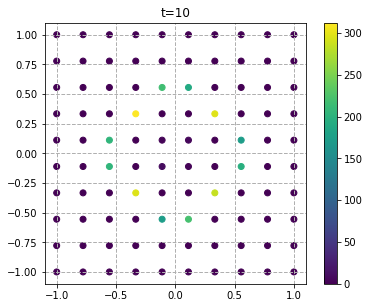

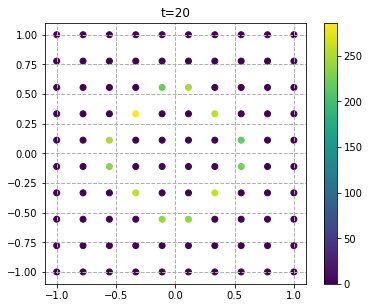

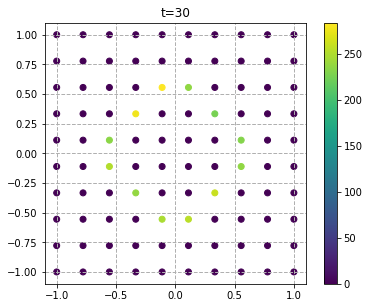

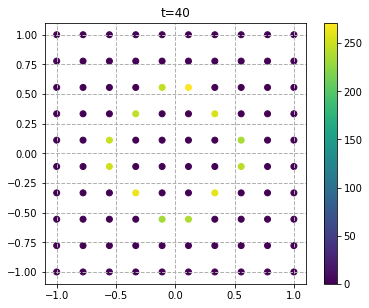

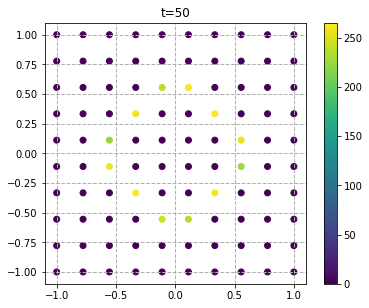

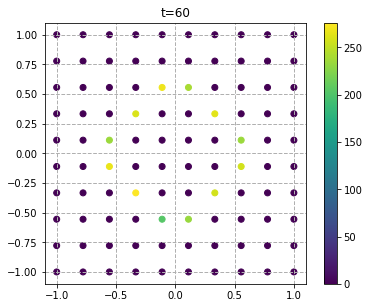

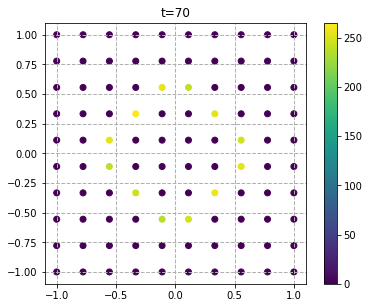

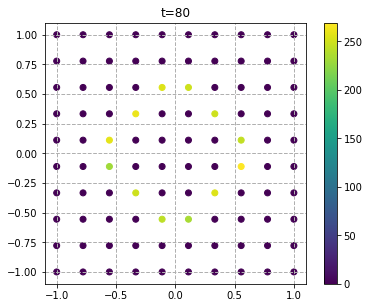

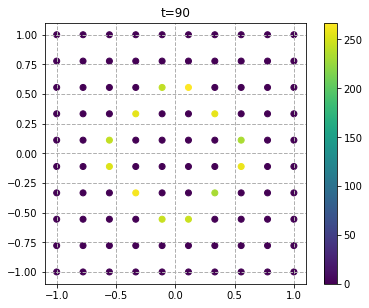

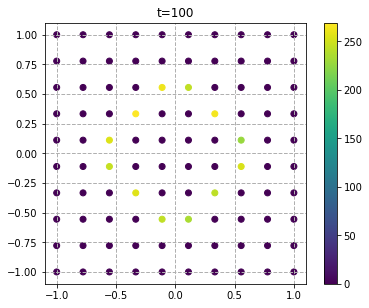

In [17]:
for i, t in enumerate(result.get_timespan()):
    if i % 10 == 0:
        result.plot_species("Cdc42_a", i, title=f"t={i}", use_matplotlib=True)